In [73]:
# Imports
from datetime import datetime, timedelta
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [74]:
# Configs
files = ["measurements/mock/Q3/jobs_1.txt", "measurements/mock/Q3/jobs_2.txt", "measurements/mock/Q3/jobs_3.txt"]
mcperf_files = ["measurements/mock/Q3/mcperf_1.txt", "measurements/mock/Q3/mcperf_2.txt", "measurements/mock/Q3/mcperf_3.txt"]
n_runs = 3

In [115]:
# Functions

# Function to get the benchmarks execution times for a provided log file (in seconds)
def get_batch_times(files):
    job_names = ['blackscholes', 'canneal', 'dedup', 'ferret', 'freqmine', 'radix', 'vips']
    execution_times = {qj: [] for qj in job_names}
    for file in files:
        start_times = {qj: None for qj in job_names}
        end_times = {qj: None for qj in job_names}
        pause_times = {qj: [] for qj in job_names}
        unpause_times = {qj: [] for qj in job_names}
        with open(file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                event = parts[1]
                job = parts[2]
                
                if event == 'start' and job in job_names:
                    start_times[job] = datetime.fromisoformat(parts[0])
                if event == 'end' and job in job_names:
                    end_times[job] = datetime.fromisoformat(parts[0])
                if event == 'pause' and job in job_names:
                    pause_times[job].append(datetime.fromisoformat(parts[0]))
                if event == 'unpause' and job in job_names:
                    unpause_times[job].append(datetime.fromisoformat(parts[0]))
            
        # Compute end - start times for each job, and remove sum of pause spans for each job if present
        for (k, v1), (_, v2) in zip(pause_times.items(), unpause_times.items()):
            if (v1 and v2) and (len(v1) == len(v2)):
                tot_pause = sum([unp - pau for unp, pau in zip(v2, v1)])
                execution_times[k].append(((end_times[k] - start_times[k]) - tot_pause).total_seconds())
            elif (not v1) and (not v2):
                execution_times[k].append((end_times[k] - start_times[k]).total_seconds())
            else:
                raise ValueError("Pause and Unpause lists are not of the same length OR one is empty and the othe not !")
    return execution_times


# Function to calculate mean and standard deviation of job time for each batch application
def calculate_batch_means_and_stds(files):
    batch_execution_times = get_batch_times(files)
    # Create mean and std dictionaries with all key-values: job_name --> mean and job_name --> std
    batch_means = {}
    batch_stds = {}
    for batch_name, execution_times in batch_execution_times.items():
        batch_means[batch_name] = statistics.mean(execution_times)
        batch_stds[batch_name] = statistics.stdev(execution_times)

    return batch_means, batch_stds


def get_total_job_times(files):
    jobs_makespans = list()
    for file in files:
        job_names = ['blackscholes', 'canneal', 'dedup', 'ferret', 'freqmine', 'radix', 'vips']
        is_first = True
        with open(file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                event = parts[1]
                job = parts[2]
                if is_first and (event == 'start') and (job in job_names):
                    start_first_job = datetime.fromisoformat(parts[0])
                    is_first = False
                if (event == 'end') and (job in job_names):
                    if len(job_names) == 1 and job_names[0] == job:
                        end_last_job = datetime.fromisoformat(parts[0])
                    else:
                        job_names.remove(job)
        jobs_makespan = (end_last_job - start_first_job).total_seconds()
        jobs_makespans.append(jobs_makespan)
    
    return jobs_makespans


# Function to parse the mcperf file
def parse_mcperf_file(file):
    with open(file, 'r') as f:
        lines = f.readlines()
        filtered_lines = [line.strip() for line in lines if line.startswith("#type") or line.startswith("read")]
    header = filtered_lines[0].split()
    column_indices = {header[i]: i for i in range(len(header))} # To get automatically the correct columns instead of hardcoding indeces
    data = {'p95': [], 'QPS':[], 'target':[]}
    for line in filtered_lines[1:]:  # To skip the header line
        parts = line.split()
        data['p95'].append(float(parts[column_indices['p95']]))
        data['QPS'].append(float(parts[column_indices['QPS']]))
        data['target'].append(float(parts[column_indices['target']]))
    df = pd.DataFrame(data)
    return df


# Compute SLO violation ration for a given run
def compute_SLO_violation_ratio(p95):
    return (p95/1000.0 > 1).sum() / len(p95)


# Function to arrange times in a format convenient for plotting
def arrange_times(batch_times, total_times, n_runs):
    arranged_times = list()
    for i in range(n_runs):
        tmp = list()
        for value in batch_times.values():
            tmp.append(value[i])
        tmp.append(total_times[i])
        arranged_times.append(tmp)
    return arranged_times


# Function to calculate relative starting times in seconds for each job
def calculate_relative_start_times(files):
    job_names = ['blackscholes', 'canneal', 'dedup', 'ferret', 'freqmine', 'radix', 'vips']
    relative_start_times = list()
    for file in files:
        start_times = list()
        with open(file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                event = parts[1]
                job = parts[2]
                if (event == 'start') and (job in job_names):
                    start_times.append(datetime.fromisoformat(parts[0]))
        min_start_time = min(start_times)
        relative_start_times.append([(start_time - min_start_time).total_seconds() for start_time in start_times])
    
    return relative_start_times

In [106]:
# Compute mean and std 
batch_times = get_batch_times(files)
batch_means, batch_stds = calculate_batch_means_and_stds(files)

print('Batch Application Means:')
for batch_name, mean in batch_means.items():
    print(f'- {batch_name}: {mean:.2f} seconds')
    
print('\nBatch Application Stds:')
for batch_name, std in batch_stds.items():
    print(f'- {batch_name}: {std:.2f} seconds')

# Calculate mean and standard deviation of the total time to complete all jobs (makespan)
total_job_times = get_total_job_times(files)
print('\nTotal Job Time Across All Files:', total_job_times)

makespan_mean = statistics.mean(total_job_times)
makespan_stdev = statistics.stdev(total_job_times)
print(f'\nMakespan Mean: {makespan_mean:.2f} seconds')
print(f'Makespan Standard Deviation: {makespan_stdev:.2f} seconds')

# Compute SLO Violation ratio
violation_ratios = list()
for file in mcperf_files:
    df = parse_mcperf_file(file)
    violation_ratios.append(compute_SLO_violation_ratio(df['p95']))
print('\nSLO Violation Ratios:', violation_ratios)

Batch Application Means:
- blackscholes: 81.99 seconds
- canneal: 149.57 seconds
- dedup: 36.14 seconds
- ferret: 212.96 seconds
- freqmine: 349.37 seconds
- radix: 36.27 seconds
- vips: 53.70 seconds

Batch Application Stds:
- blackscholes: 6.41 seconds
- canneal: 10.09 seconds
- dedup: 5.86 seconds
- ferret: 29.39 seconds
- freqmine: 0.16 seconds
- radix: 5.60 seconds
- vips: 5.31 seconds

Total Job Time Across All Files: [950.621915, 948.418829, 869.159406]

Makespan Mean: 922.73 seconds
Makespan Standard Deviation: 46.41 seconds

SLO Violation Ratios: [0.008333333333333333, 0.0, 0.008333333333333333]


In [117]:
# Get the batch times and the total times across all runs
batch_times = get_batch_times(files)
total_times = get_total_job_times(files)

# Arrange times for convenient plotting
arranged_times = arrange_times(batch_times, total_times, n_runs)

# Get the relative job time spans wrt the first run job(s)
relative_start_times = calculate_relative_start_times(files)

# Get dataframes of interest from mcperf files and compute memcached timespan
mcperf_dfs = list()
memcached_spans = list()
for file in mcperf_files:
    df = parse_mcperf_file(file)
    mcperf_dfs.append(df)

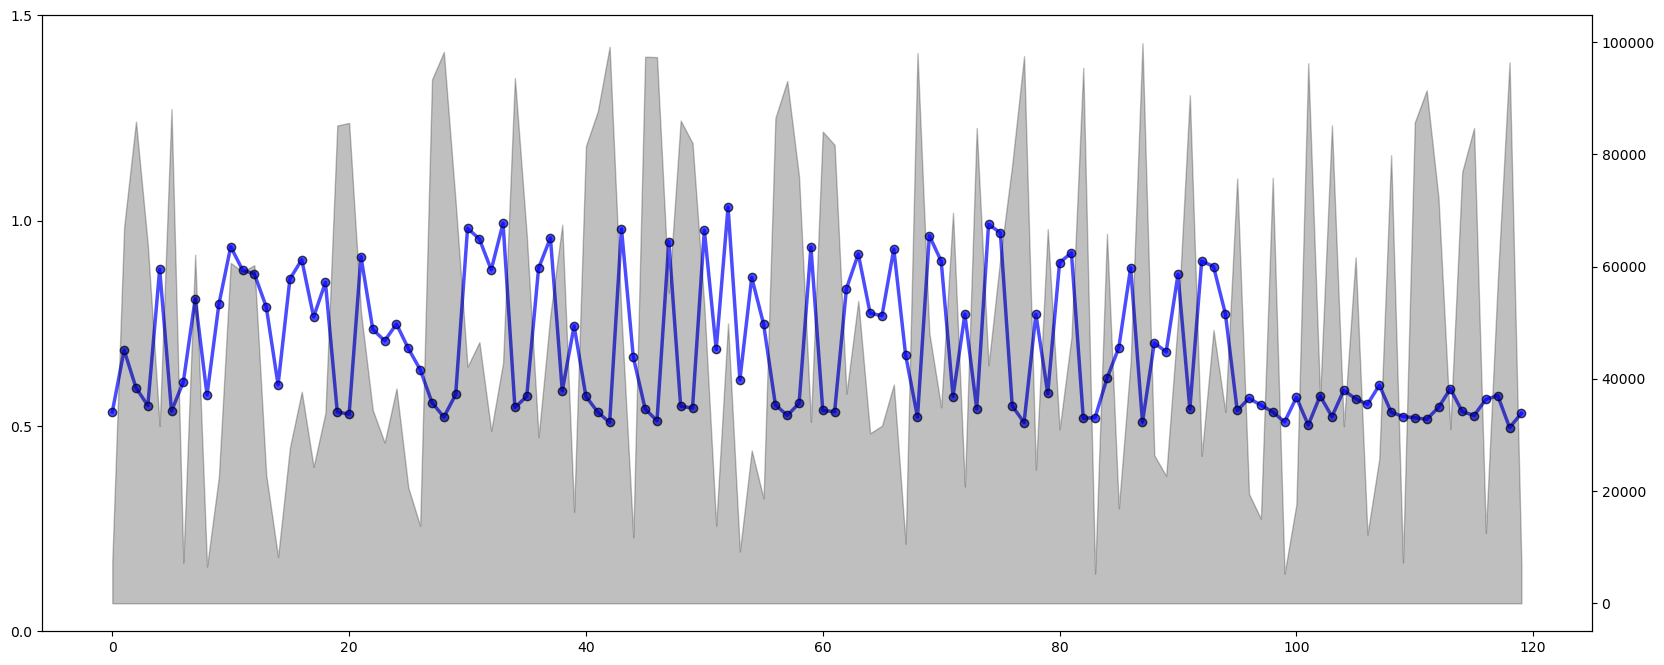

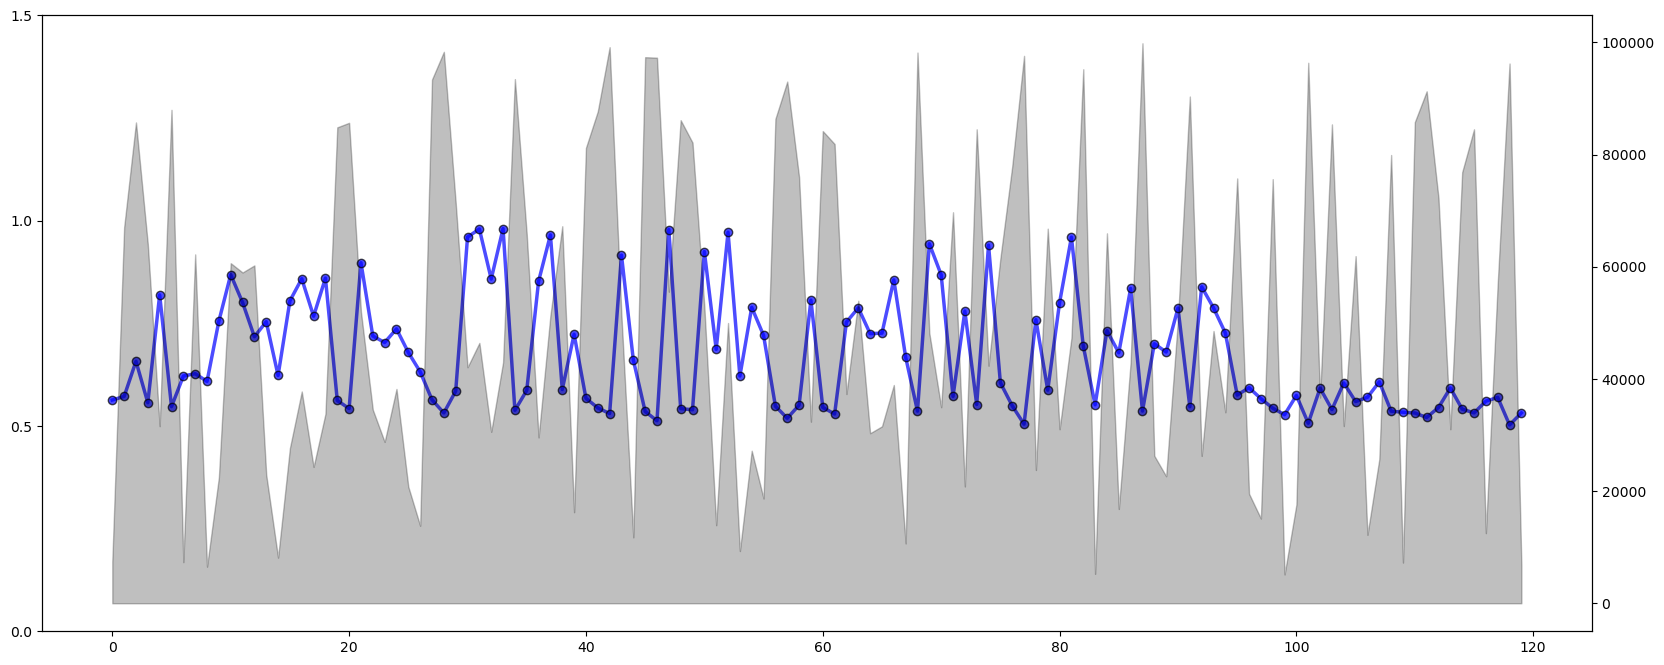

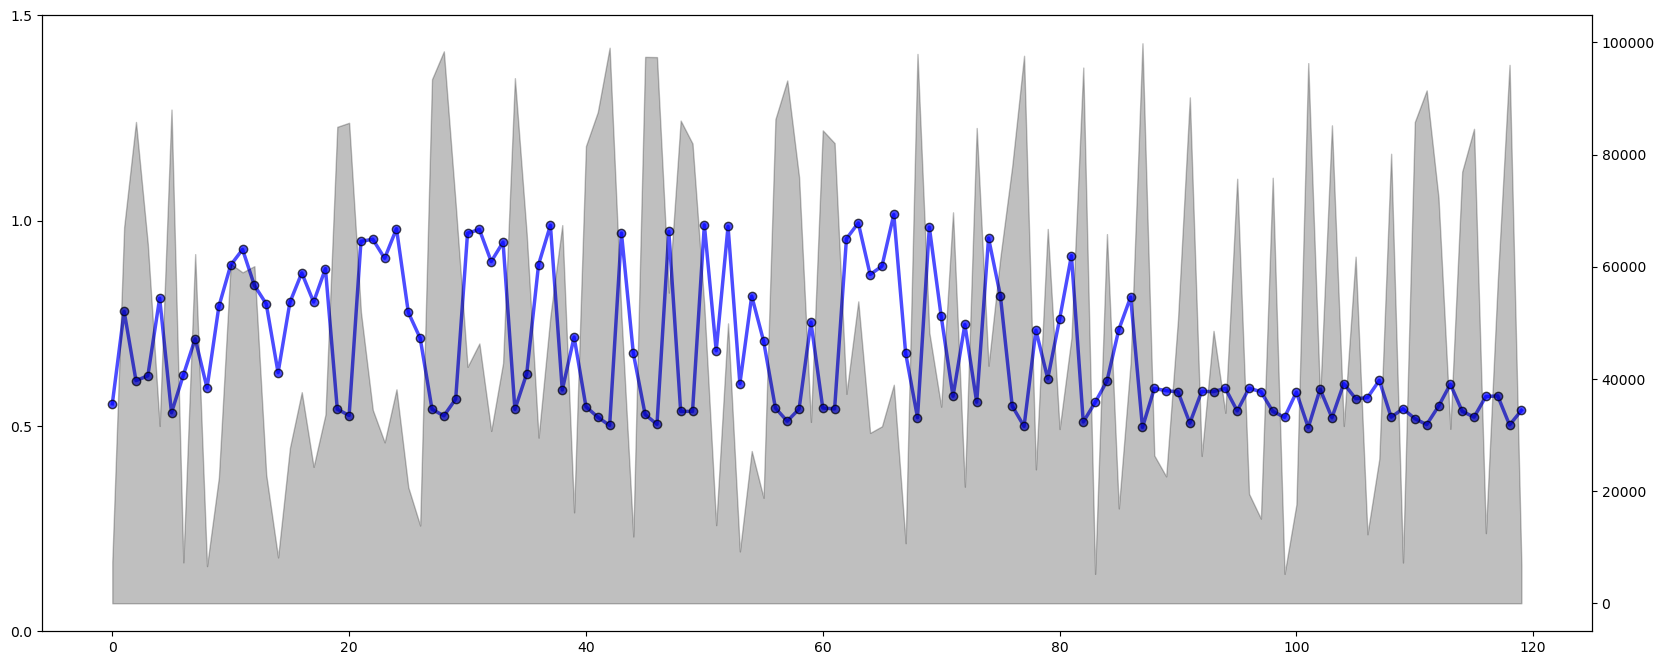

In [162]:
# Plots (A)
colors = {'canneal': '#CCCCAA', 'dedup': '#CCACCA', 'blackscholes': '#CCA000',
          'ferret': '#AACCCA', 'freqmine': '#0CCA00',
          'memcached': 'grey', 'radix': '#00CCA0', 'vips': '#CC0A00'}
jobs = ['blackscholes', 'canneal', 'dedup', 'ferret', 'freqmine', 'radix', 'vips']
jobs_pos_hbars = [(16, 1), (17, 1), (17, 1), (10, 4), (10, 4), (4, 4), (2, 2)]
jobs_pos_annotations = [16.5, 17.5, 17.5, 12, 12, 6, 3]

for i, df in enumerate(mcperf_dfs):
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,8), dpi=100)
    fig.subplots_adjust(hspace=0.3)
    
    ## ------ First Subplot ------ ##
    xticks = range(0, 120)
    ax1.plot(xticks, df['p95']/1000, marker='o', linewidth=2.5, alpha=0.7, markersize=6, 
            color='#0000ff', markeredgewidth=1, markeredgecolor='black')
    ax1.set_yticks( np.arange(0, 2, 0.5).tolist())
    
    ax2 = ax1.twinx()
    
    ax2.fill_between(xticks, df['QPS'], color='black', alpha=0.25)
    
    # Style
    
    
    plt.show()
    #plt.savefig("plot_" + str(i) + ".pdf", bbox_inches = "tight")